# Kaggle 문제
- https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

# Import Packages

In [15]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from copy import deepcopy
import time

# Setup Seed

In [16]:
import random
import os

# Device 설정

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

seed = 42 # seed 값 설정
random.seed(seed) # 파이썬 난수 생성기
os.environ['PYTHONHASHSEED'] = str(seed) # 해시 시크릿값 고정
np.random.seed(seed) # 넘파이 난수 생성기

torch.manual_seed(seed) # 파이토치 CPU 난수 생성기
torch.backends.cudnn.deterministic = True # 확정적 연산 사용 설정
torch.backends.cudnn.benchmark = False # 벤치마크 기능 사용 해제
torch.backends.cudnn.enabled = False # cudnn 기능 사용 해제

if device == 'cuda':
  torch.cuda.manual_seed(seed) # 파이토치 GPU 난수 생성기
  torch.cuda.manual_seed_all(seed) # 파이토치 멀티 GPU 난수 생성

cuda


# Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare Data

In [22]:
import os, shutil

original_data_path = '000_data\\dogs-vs-cats'
os.makedirs('000_data\\dogsvscats', exist_ok=True)

import zipfile

with zipfile.ZipFile(os.path.join(original_data_path, 'train.zip')) as train_zip:
  train_zip.extractall('000_data\\dogsvscats')

with zipfile.ZipFile(os.path.join(original_data_path, 'test.zip')) as test_zip:
  test_zip.extractall('000_data\\dogsvscats')

import glob

from sklearn.model_selection import train_test_split

train_dir = '000_data\\dogsvscats\\train'
test_dir = '000_data\\dogsvscats\\test'
# glob : 특정 path에 있는 파일 리스트를 가져오는 명령
all_train_files = glob.glob(os.path.join(train_dir, '*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
# all_train_files를 리스트 컴프리헨션으로 경로를 '\'를 기준으로 split하고 또 가져온 값에서 '.'을 기준으로 split해서 label을 가져온다.
train_labels = [path.split('\\')[-1].split('.')[0] for path in all_train_files]
train_list, val_list = train_test_split(all_train_files, test_size = 0.1, stratify = train_labels, random_state = seed)
print(len(train_list), len(val_list))

22500 2500


In [25]:
train_list[0]

'000_data\\dogsvscats\\train\\cat.4814.jpg'

# Reference: check image data
- Check image size

In [26]:
img = Image.open('000_data\\dogsvscats\\train\\cat.733.jpg')
img.size

(415, 499)

- See image

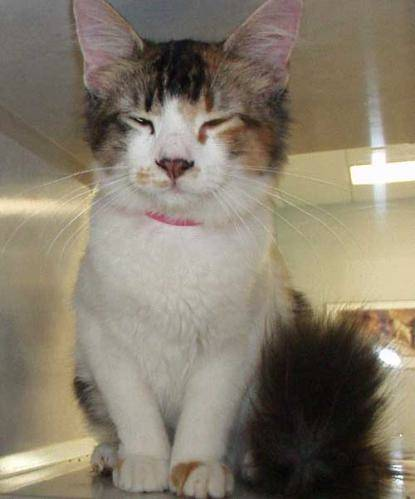

In [27]:
import IPython

image1 = IPython.display.Image(filename='000_data\\dogsvscats\\train\\cat.733.jpg')
display(image1)

# Prepare dataset

In [38]:
from torchvision import transforms

# 이미지 사이즈를 224로 하는 이유는 보통 pre-trained된 모델의 imagenet-21k이 224x224이다.
input_size = 224
transforms_for_train = transforms.Compose([
    transforms.RandomResizedCrop(input_size, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

transforms_for_val_test = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

# class Dataset
class CustomDataset(Dataset):
  def __init__(self, file_list, transform=None):
    self.file_list = file_list
    self.transform = transform

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self, idx):
    img_path = self.file_list[idx]
    if img_path.split('\\')[-1][-3:] == 'jpg':
      img = Image.open(img_path)
      if self.transform is not None:
        img_transform = self.transform(img)
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'dog':
          label = 1
        elif label == 'cat':
          label = 0
    return img_transform, label

dataset_train = CustomDataset(train_list, transform=transforms_for_train)
dataset_valid = CustomDataset(val_list, transform=transforms_for_val_test)
dataset_test = CustomDataset(test_list, transform=transforms_for_val_test)

from torch.utils.data import DataLoader

train_batches = DataLoader(dataset=dataset_train, batch_size=8, shuffle=True)
val_batches = DataLoader(dataset=dataset_valid, batch_size=8, shuffle=False)
test_batches =DataLoader(dataset=dataset_test, batch_size=8, shuffle=False)

# Create model

In [ ]:
!pip install -q timm transformers

In [39]:
import timm

model = timm.create_model("vit_base_patch32_224_in21k", pretrained=True)
model.head = nn.Sequential(
    nn.Linear(768, 21843, bias=True),
    nn.LeakyReLU(),
    nn.BatchNorm1d(21843),
    nn.Linear(21843, 512, bias=True),
    nn.LeakyReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 1, bias=True),
    nn.Sigmoid()
)
model.to(device)
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# learning rate scheduler
# 학습률을 스텝마다(여기선 에포크) 줄이거나 늘려주는것
# warmup은 초기 학습값을 점점 크게, training은 점점 작게
# from transformers import get_linear_schedule_with_warmup
# scheduler = get_linear_schedule_with_warmup(
#     optimizer,
#     num_warmup_steps = 0,
#     num_training_steps = 10
# )

# Define Train Function

In [40]:
def train_model(model, criterion, optimizer, early_stop, epochs, train_loader, valid_loader):
  train_losses, train_accuracies, valid_losses, valid_accuracies, lowest_loss, lowest_epoch = list(), list(), list(), list(), np.inf, 0

  # DEBUG
  progress_count = 0

  for epoch in range(epochs):
    train_loss, train_accuracy, train_corrects, valid_loss, valid_accuracy, valid_corrects = 0, 0, 0, 0, 0, 0
    train_correct, valid_correct = 0, 0

    start = time.time()
    model.train()
    for train_x, train_y in train_loader:
      train_x = train_x.to(device)
      train_y = train_y.to(device).float()
      train_y = train_y.view(train_y.size(0), -1)
      pred = model(train_x)
      loss = criterion(pred, train_y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

      y_pred = np.round(pred.detach().cpu()) # pred 값을 반올림하여 0과 1로 저장한다.
      train_correct += y_pred.eq(train_y.detach().cpu()).sum().item() # y_pred 값을 train_y와 비교하여 맞은 개수만 저장

      # DEBUG
      # if (progress_count % 10) == 0:
      #   print(y_pred.eq(train_y.detach().cpu()).sum().item(), len(y_pred))
      # progress_count += 1

    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = train_correct / len(train_loader.dataset)
    train_accuracies.append(train_accuracy)

    model.eval()
    with torch.no_grad():
      for valid_x, valid_y in valid_loader:
        valid_x = valid_x.to(device)
        valid_y = valid_y.to(device).float()
        valid_y = valid_y.view(valid_y.size(0), -1)
        pred = model(valid_x)
        loss = criterion(pred, valid_y)
        valid_loss += loss.item()

        y_pred = np.round(pred.detach().cpu())
        valid_correct += y_pred.eq(valid_y.detach().cpu()).sum().item()

    valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)
    valid_accuracy = valid_correct / len(valid_loader.dataset)
    valid_accuracies.append(valid_accuracy)

    elapsed_time = time.time() - start
    print(f'[Epoch {epoch+1}/{epochs}]: {elapsed_time:.3f} sec(elapsed_time), train loss: {train_losses[-1]:.4f}, train acc: {train_accuracy * 100:.3f}% / valid loss: {valid_losses[-1]:.4f}, valid acc: {valid_accuracy * 100:.3f}%')

    if valid_losses[-1] < lowest_loss:
      lowest_loss = valid_losses[-1]
      lowest_epoch = epoch
      best_model = deepcopy(model.state_dict())
    else:
      if (early_stop > 0) and lowest_epoch + early_stop < epoch:
        print("Early Stopped", epoch, "epochs")
        break

    # scheduler.step()

  model.load_state_dict(best_model)
  return model, lowest_loss, train_losses, valid_losses, train_accuracies, valid_accuracies

# Training

In [ ]:
model, lowest_loss, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, loss_func, optimizer, 0, 30, train_batches, val_batches)

4 8
7 8
7 8
8 8
7 8
7 8
6 8
8 8
7 8
8 8
8 8
8 8
7 8
7 8
8 8
8 8
8 8
7 8
8 8
7 8
8 8
7 8
7 8
8 8
7 8
8 8
6 8
8 8
8 8
8 8
8 8
7 8
8 8
8 8
8 8
8 8
8 8
8 8
7 8
7 8
8 8
8 8
7 8
8 8
8 8
7 8
8 8
8 8
6 8
8 8
7 8
8 8
7 8
8 8
7 8
8 8
8 8
8 8
8 8
8 8
8 8
5 8
8 8
8 8
8 8
7 8
6 8
7 8
8 8
4 8
8 8
8 8
7 8
7 8
7 8
8 8
8 8
6 8
8 8
8 8
8 8
7 8
7 8
7 8
8 8
8 8
8 8
8 8
7 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
7 8
7 8
8 8
8 8
8 8
8 8
6 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
7 8
8 8
8 8
8 8
8 8
7 8
8 8
8 8
8 8
7 8
8 8
7 8
7 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
7 8
8 8
8 8
7 8
8 8
8 8
8 8
7 8
8 8
8 8
8 8
8 8
7 8
8 8
8 8
7 8
8 8
8 8
8 8
8 8
7 8
7 8
8 8
8 8
8 8
8 8
8 8
8 8
7 8
8 8
7 8
7 8
7 8
8 8
8 8
7 8
6 8
7 8
8 8
8 8
8 8
8 8
6 8
8 8
7 8
8 8
8 8
8 8
8 8
7 8
8 8
8 8
7 8
7 8
8 8
8 8
6 8
8 8
7 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
6 8
6 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
7 8
4 8
8 8
8 8
8 8
7 8
7 8
7 8
8 8
8 8
8 8
8 8
8 8
8 8
3 8
8 8
8 8
7 8
8 8
7 8
7 8
8 8
8 8
7 8
8 8
8 8
8 8
8 8
7 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8
8 8


# Save Model

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/000_data/dogs-vs-cats/'
torch.save(model.state_dict(), PATH + 'model_vit_base_patch32_224_in21k_linear_without_schedule_adam_1e5_epoch30.pth')

# Load Model

In [41]:
PATH = '000_data\\dogs-vs-cats\\'
model.load_state_dict(torch.load(PATH + 'model_vit_base_patch32_224_in21k_linear_schedule_with_warmup_adam_1e5.pth'))

<All keys matched successfully>

# Predict & Submit

In [42]:
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
dataset_test = CustomDataset(test_list, transform=transforms_for_val_test)
test_batches = DataLoader(dataset=dataset_test, batch_size=8, shuffle=False)

def predict(model, data_loader):
  ids = list()
  with torch.no_grad():
    model.eval()
    ret = None
    for img, fileid in data_loader:
      img = img.to(device)
      pred = model(img)
      ids += list(fileid) # 리스트 형태로 파일 ID가 8개씩 들어감
      if ret is None:
        ret = pred.cpu().numpy() # 처음에 ret에 pred를 numpy 형태로 그대로 저장
      else:
        ret = np.vstack([ret, pred.cpu().numpy()]) # 두번째부터 ret에 pred를 스택으로 저장
  return ret, ids

pred, ids = predict(model, test_batches)

In [43]:
print(pred.shape, len(ids))

(12500, 1) 12500


# Submission

In [44]:
# id에 ids를 추가하고, label에 pred를 추가하는데 제출 수식에 로그가 포함되어 있으므로 최소 0.006 ~ 최대 1-0.006으로 범위를 설정하고, squeeze로 벡터로 바꾼다.
submission = pd.DataFrame({'id': ids, 'label': np.clip(pred, 0.006, 1-0.006).squeeze()})
# id를 정렬한다.
submission.sort_values(by='id', inplace=True)
# index 번호 열(순서)을 지운다.
submission.reset_index(drop=True, inplace=True)
submission.to_csv('submission.csv', index=False)

# Test for Optimal Cliping

In [ ]:
# id에 ids를 추가하고, label에 pred를 추가하는데 제출 수식에 로그가 포함되어 있으므로 최소 0.005 ~ 최대 1-0.005으로 범위를 설정하고, squeeze로 벡터로 바꾼다.
submission = pd.DataFrame({'id': ids, 'label': np.clip(pred, 0.007, 1-0.007).squeeze()})
# id를 정렬한다.
submission.sort_values(by='id', inplace=True)
# index 번호 열(순서)을 지운다.
submission.reset_index(drop=True, inplace=True)
submission.to_csv('submission.csv', index=False)